In [1]:
import re, os, sys, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame
    
numpy.random.seed(7)

### Analysis dirs

In [2]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

### Local code in the scripts dir on the cluster

In [3]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes


### Plotting setup

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

# Silence deprecation warnings

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

# Load meta data

In [6]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

# Is archaic admixture lower in low pi regions?

Barplots show the mean admix prop of individuals (not populations)

Load admixture data:

In [7]:
admix_windows_chrX = pandas.read_hdf(results_dir / 'admix_windows_chrX.hdf')

Load sweep data:

In [8]:
abs_low_window_chrX_df = pandas.read_hdf(results_dir / 'abs_low_window_chrX_df.hdf')

with open(str(results_dir / 'min_run_length.pkl'), 'rb') as f:
    min_run_length = pickle.load(f)

Load auxiliary data:

In [9]:
phastcons_windows = pandas.read_hdf(results_dir / 'phastcons_windows.hdf')
refseq_density = pandas.read_hdf(results_dir / 'refseq_density.hdf')
admix_windows_chrX = pandas.read_hdf(results_dir / 'admix_windows_chrX.hdf')
admix_1Mb_windows_chrX = pandas.read_hdf(results_dir / 'admix_1Mb_windows_chrX.hdf')

Globally:

In [10]:
#admix_windows_chrX.loc[lambda df: (df.start == 103000000) & (df.admix_prop > 0)]

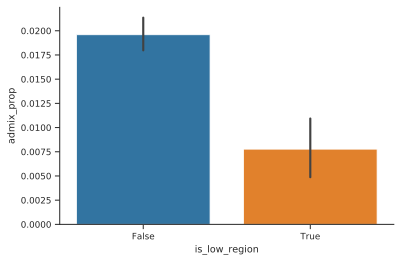

In [11]:
with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        abs_low_window_chrX_with_admix = (pandas.merge(abs_low_window_chrX_df,
                           admix_windows_chrX[['chrom', 'start', 'end', 'region', 'population', 'admix_prop']],
                           on=['chrom', 'population', 'region', 'start', 'end'])
        #        .assign(is_low_region = lambda df: (df.islow) & (df.run >= min_run_length))
             )
        g = sns.barplot(x="is_low_region", y="admix_prop", data=abs_low_window_chrX_with_admix)
        sns.despine()
        
plt.savefig(str(figures_dir / "admix_prop_enrichment.pdf"))

By region:

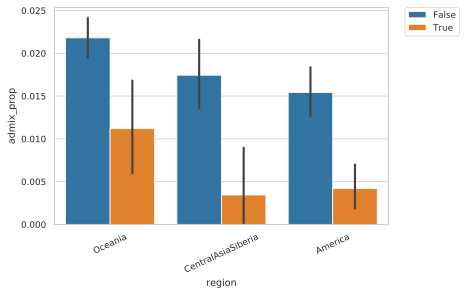

In [12]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid'):
        g = sns.barplot(x="region", y="admix_prop", hue="is_low_region", 
                        data=abs_low_window_chrX_with_admix#.loc[lambda df: df.population != 'Papuan']
                       )
        for item in g.get_xticklabels():
            item.set_rotation(25)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(str(figures_dir / "admix_prop_enrichment_by_region.pdf"))

# Proportion explained by gene density

### Logistic regression to classify low/non-low pi regions by admix and exon density

In [13]:

df = pandas.merge(abs_low_window_chrX_df,
                   admix_windows_chrX[['chrom', 'start', 'end', 'region', 'population', 'admix_prop']],
                   on=['chrom', 'population', 'region', 'start', 'end'])
df = pandas.merge(df, phastcons_windows.loc[lambda df: df.chrom == 'X'],
                   on=['chrom', 'start', 'end'])
df = (pandas.merge(df, refseq_density, on=['chrom', 'start', 'end'])
      .assign(is_low_region = lambda df: (df.islow) & (df.run <= min_run_length))
      .groupby(['chrom', 'population', 'region', 'run_id'])
      .aggregate(numpy.mean)
      .reset_index()
     )
df = df[['is_low_region', 'exon_density', 'admix_prop', 'phastcons']]

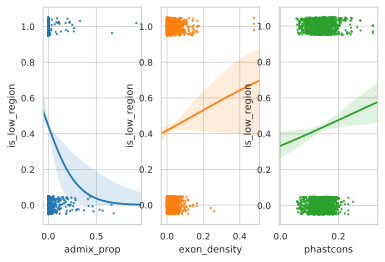

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax = sns.regplot(x="admix_prop", y="is_low_region", 
                 data=df, logistic=True, y_jitter=.05, scatter_kws={'s':2}, ax=ax1)
ax = sns.regplot(x="exon_density", y="is_low_region", 
                 data=df, logistic=True, y_jitter=.05, scatter_kws={'s':2}, ax=ax2)
ax = sns.regplot(x="phastcons", y="is_low_region", 
                 data=df, logistic=True, y_jitter=.05, scatter_kws={'s':2}, ax=ax3)

In [15]:
from sklearn import linear_model
X = df[['admix_prop', 'exon_density', 'phastcons']]
y = df['is_low_region']
lr = linear_model.LogisticRegression()
lr.fit(X, y)
#print(lr.predict(X))
DataFrame(dict(zip(X.columns, numpy.transpose(lr.coef_))))

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


admix_prop  exon_density  phastcons
0   -2.530722      0.719302   1.037904

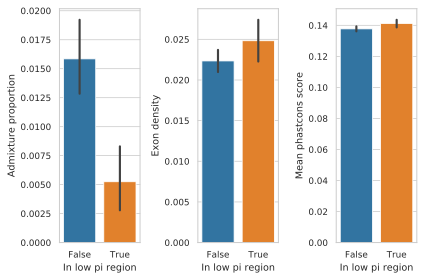

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax = sns.barplot(x="is_low_region", y="admix_prop", data=df, ax=ax1)
ax.set(xlabel='In low pi region', ylabel='Admixture proportion')
ax = sns.barplot(x="is_low_region", y="exon_density", data=df, ax=ax2)
ax.set(xlabel='In low pi region', ylabel='Exon density')
ax = sns.barplot(x="is_low_region", y="phastcons", data=df, ax=ax3)
ax.set(xlabel='In low pi region', ylabel='Mean phastcons score')
plt.tight_layout()
plt.savefig(str(figures_dir / "admix_exon_phastcons_enrichment.pdf"))

# Two-wave hypothesis

In [17]:
cols = ['chrom', 'start', 'end']

df = (abs_low_window_chrX_with_admix
                       .join(abs_low_window_chrX_with_admix.groupby(cols)['islow'].any(), on=cols, rsuffix='_any')
                       .join(abs_low_window_chrX_with_admix.groupby(cols)['islow'].sum(), on=cols, rsuffix='_count')
                       .join(abs_low_window_chrX_with_admix.groupby(cols)['is_low_region'].any(), on=cols, rsuffix='_any')
                       .join(abs_low_window_chrX_with_admix.groupby(cols)['is_low_region'].sum(), on=cols, rsuffix='_count')
                      )

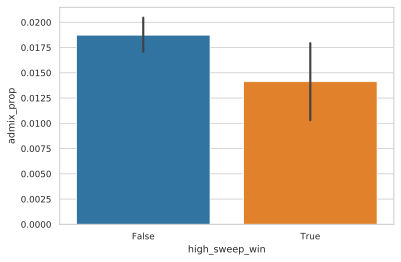

In [18]:
sns.barplot(x="high_sweep_win", y="admix_prop",
       data=df.assign(high_sweep_win = lambda df: df.is_low_region_count > len(df.population.unique())/2))

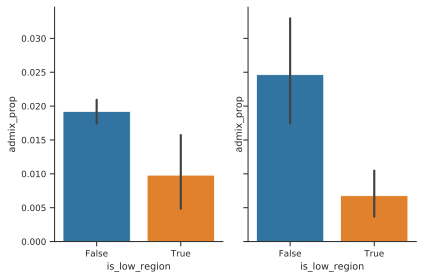

In [19]:
with sns.axes_style("ticks"):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    sns.barplot(x="is_low_region", y="admix_prop", 
                    data=df.loc[lambda df: df.is_low_region_count < len(df.population.unique())/2], ax=ax1)
    sns.barplot(x="is_low_region", y="admix_prop", 
                    data=df.loc[lambda df: df.is_low_region_count >= len(df.population.unique())/2], ax=ax2)
    sns.despine()
    plt.tight_layout()

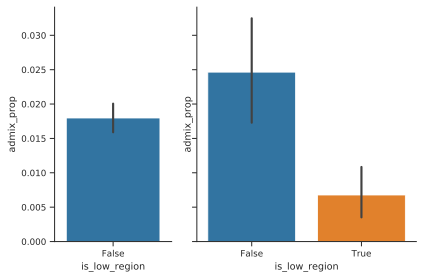

In [20]:
# fig = plt.figure(figsize=(8, 6), sharey=True) 
# gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
# ax0 = plt.subplot(gs[0])
# ax0.plot(x, y)
# ax1 = plt.subplot(gs[1])
# ax1.plot(y, x)

with sns.axes_style("ticks"):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [8, 15]})
    sns.barplot(x="is_low_region", y="admix_prop", 
                    data=df.loc[lambda df: df.is_low_region_count == 0], ax=ax1)
    sns.barplot(x="is_low_region", y="admix_prop", 
                    data=df.loc[lambda df: df.is_low_region_count >= len(df.population.unique())/2])
    sns.despine()
    plt.tight_layout()

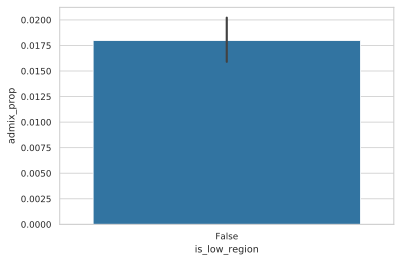

In [21]:
g = sns.barplot(x="is_low_region", y="admix_prop", 
                data=df.loc[lambda df: df.is_low_region_count == 0])

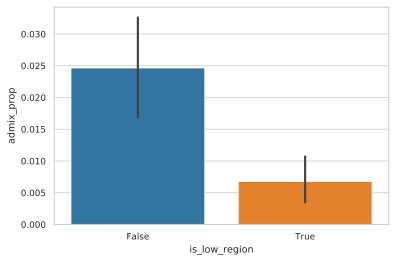

In [22]:

g = sns.barplot(x="is_low_region", y="admix_prop", 
                data=df.loc[lambda df: df.is_low_region_count >= len(df.population.unique())/2])

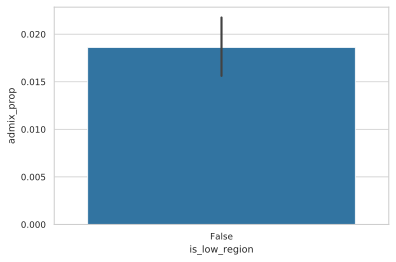

In [23]:
g = sns.barplot(x="is_low_region", y="admix_prop", 
                data=df.loc[lambda df: df.islow_count == 0])

In [24]:
low_region_count_median = df.is_low_region_count.median()
islow_count_median = df.islow_count.median()

g = sns.barplot(x="is_low_region", y="admix_prop", 
                data=df.loc[lambda df: df.is_low_region_count < low_region_count_median])

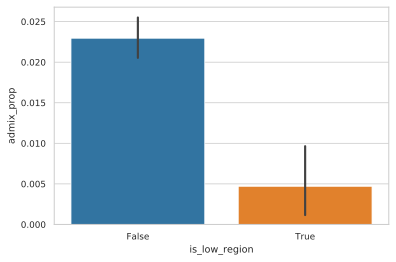

In [25]:
g = sns.barplot(x="is_low_region", y="admix_prop", 
                data=df.loc[lambda df: df.islow_count < islow_count_median])

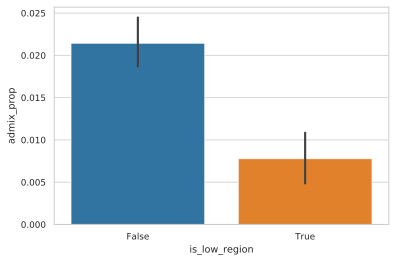

In [26]:
g = sns.barplot(x="is_low_region", y="admix_prop", 
                data=df.loc[lambda df: df.is_low_region_count >= low_region_count_median])

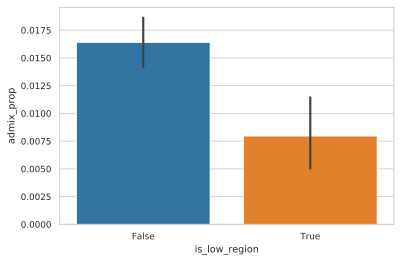

In [27]:
g = sns.barplot(x="is_low_region", y="admix_prop", 
                data=df.loc[lambda df: df.islow_count >= islow_count_median])

In [28]:
cols = ['chrom', 'start', 'end']

admix_by_low_pop_count = (abs_low_window_chrX_with_admix
                       .join(df.groupby(cols)['is_low_region'].any(), on=cols, rsuffix='_any')
                       .join(df.groupby(cols)['is_low_region'].sum(), on=cols, rsuffix='_count')
                      )

g = sns.catplot(x="is_low_region_count", y="admix_prop", 
                   data=admix_by_low_pop_count, height=5, aspect=1.8)


In [33]:
#g = sns.barplot(x="is_low_region", y="admix_prop", data=df.loc[lambda df: df.is_low_region_count >= 50])

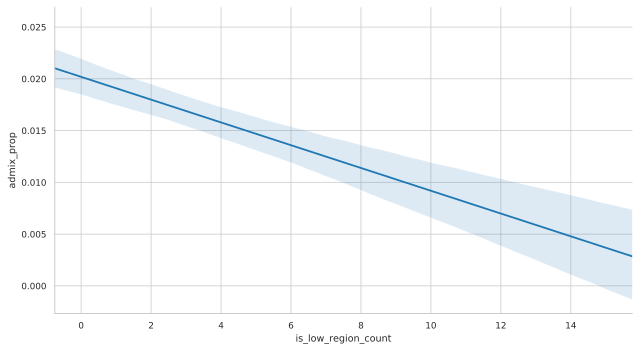

In [31]:
g = sns.lmplot(x="is_low_region_count", y="admix_prop", 
                   data=admix_by_low_pop_count, height=5, aspect=1.8, scatter=False)

In [34]:
#print(only_low_region_any.size)
#fig, ax = plt.subplots(figsize=(10, 5))ma
g = sns.catplot(x="is_low_region_count", y="admix_prop", hue='is_low_region', 
                   data=admix_by_low_pop_count, height=5, aspect=1.8)


It seems that the reduction in admixture proportion is insensitive to how much chromosomal region we include, suggesting that the reduction is existance of the existance of individual low regions in each population, and not by by what chromosomal region is included.

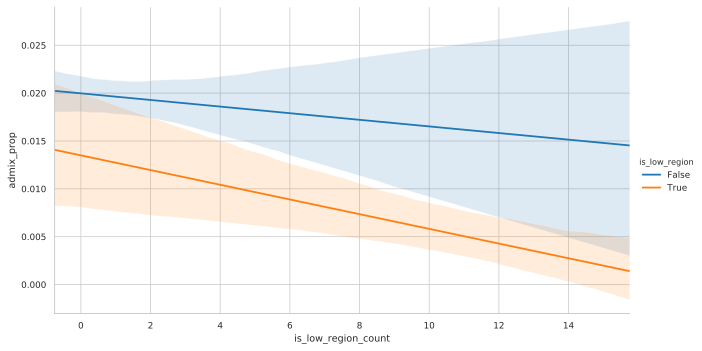

In [35]:
g = sns.lmplot(x="is_low_region_count", y="admix_prop", hue='is_low_region',
                   data=admix_by_low_pop_count, height=5, aspect=1.8, scatter=False)

*** TODO: Figure out to what extent there really is a depletion in some regions and to what extent it is explained by the density of low pi regions.***

In [36]:
print(admix_by_low_pop_count.loc[(admix_by_low_pop_count.is_low_region_count == 0) & (~admix_by_low_pop_count.is_low_region)].admix_prop.mean())
print(admix_by_low_pop_count.loc[(admix_by_low_pop_count.is_low_region_count < 20) & (~admix_by_low_pop_count.is_low_region)].admix_prop.mean())
print(admix_by_low_pop_count.loc[(admix_by_low_pop_count.is_low_region_count >= 20) & (~admix_by_low_pop_count.is_low_region)].admix_prop.mean())

print(admix_by_low_pop_count.loc[(admix_by_low_pop_count.is_low_region_count < 20) & (admix_by_low_pop_count.is_low_region)].admix_prop.mean())
print(admix_by_low_pop_count.loc[(admix_by_low_pop_count.is_low_region_count >= 20) & (admix_by_low_pop_count.is_low_region)].admix_prop.mean())


0.017974923113319136
0.019587413912933595
nan
0.007771260997067447
nan


# Distance to Africans normalized by mean African pi

Load pi data:

In [37]:
pi_data_chrX = pandas.read_hdf(results_dir / 'pi_data_chrX.hdf')

First compute mean pi across the African populations:

In [38]:
mean_afr_pi = (pi_data_chrX
               .loc[lambda df: df.region == 'Africa']
               .groupby(['chrom', 'start', 'end'])
               .mean()
               .reset_index()
               .assign(mean_afr_pi=lambda df: df.pi)
               .loc[:, ['chrom', 'start', 'end', 'mean_afr_pi']]
              )

**FIX THIS**: HACK: a few african means are zero, so we make then nan to not have division by zero errors propgate

In [39]:
mean_afr_pi.loc[lambda df: df.mean_afr_pi == 0]

chrom      start        end  mean_afr_pi
11       X    1100000    1200000          0.0
525      X   52500000   52600000          0.0
526      X   52600000   52700000          0.0
527      X   52700000   52800000          0.0
585      X   58500000   58600000          0.0
618      X   61800000   61900000          0.0
721      X   72100000   72200000          0.0
894      X   89400000   89500000          0.0
897      X   89700000   89800000          0.0
910      X   91000000   91100000          0.0
912      X   91200000   91300000          0.0
913      X   91300000   91400000          0.0
919      X   91900000   92000000          0.0
1015     X  101500000  101600000          0.0

In [40]:
mean_afr_pi.loc[lambda df: df.mean_afr_pi == 0] = numpy.nan
#g = plt.plot(mean_afr_pi.start, mean_afr_pi.mean_afr_pi)

Read dist data and add distance normalized with mean_afr_pi:

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df = (pandas.read_hdf(str(dist_dir / '_dist_data_chrX_100kb.store'))
          .groupby(['chrom', 'start', 'end', 'indiv_1'])
          .aggregate(numpy.nanmean)
         )
df.head()



In [ ]:
df2 = pandas.read_hdf(str(root_dir / 'mean_dist.hdf'), 'df')
df2.head()

In [ ]:
dist_data = (pandas.merge(pandas.read_hdf(str(root_dir / 'mean_dist.hdf'), 'df'),
                          mean_afr_pi,
                          how='left', 
                          on=['chrom', 'start', 'end'])
             .assign(norm_dist = lambda df: df.dist / df.mean_afr_pi)
            )

### Divergence from closest African (NOT SURE THIS MAKES SENSE HEN NORMALIZING WITH MEAN AFR PI)

In [ ]:
min_dist_data = (dist_data
                  .assign(population=[individuals[x]['Population ID'] for x in dist_data.indiv_1])
                  .groupby(['chrom', 'start', 'end', 'population'])
                  .min()
                  .reset_index()
                 )
df = pandas.merge(abs_low_window_chrX_df, 
                  min_dist_data, 
                  on=['chrom', 'start', 'end', 'population'])

In [ ]:
# df[['chrom', 'is_low_region', 'pi', 'dist', 'dist', 'norm_dist']].groupby('is_low_region').mean()

In [ ]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, ax = plt.subplots(1,1, figsize=(5,6))
            g = sns.barplot(x="is_low_region", y="norm_dist", data=df, ax=ax)
plt.savefig(str(figures_dir / "distance_to_closest_african.pdf"))

In [ ]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            g = sns.barplot(x="region", y="norm_dist", hue='is_low_region', data=df)
            for item in g.get_xticklabels():
                item.set_rotation(25)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(str(figures_dir / "distance_to_closest_african_by_region.pdf"))

### Mean distance to Africans

In [ ]:
mean_dist_data = (dist_data
                  .assign(population=[individuals[x]['Population ID'] for x in dist_data.indiv_1])
                  .groupby(['chrom', 'start', 'end', 'population'])
                  .mean()
                  .reset_index()
                 )
df = pandas.merge(abs_low_window_chrX_df, 
                  mean_dist_data, 
                  on=['chrom', 'start', 'end', 'population'])

In [ ]:
df[['chrom', 'is_low_region', 'pi', 'dist', 'dist', 'norm_dist']].groupby('is_low_region').mean()

In [ ]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, ax = plt.subplots(1,1, figsize=(5,6))
            g = sns.barplot(x="is_low_region", y="norm_dist", data=df, ax=ax)
            plt.ylim(1, 1.12)
plt.savefig(str(figures_dir / "mean_distance_to_africans.pdf"))

In [ ]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            g = sns.barplot(x="region", y="norm_dist", hue='is_low_region', data=df)
            for item in g.get_xticklabels():
                item.set_rotation(25)
            plt.ylim(1, 1.15)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(str(figures_dir / "mean_distance_to_africans_by_region.pdf"))

The extra admixture in non-low regions ofcause contributes to the divergence in these regions makeing the mean hihger. But assuming the admixture proportions in low pi and non-low pi regions we need a ratio of neandertal divergence and africa divergence of roughly 40 (e.g. 2mill / 50k) to explain it all.

In [ ]:
# (1 - 0.002) * x + 0.002 * y
# (1 - 0.012) * x + 0.012 * y

# (1 - 0.002) + 0.002 * y/x
# (1 - 0.012) + 0.012 * y/x

low_pi_mean_dist_afr = float(df.groupby('is_low_region').mean().reset_index().loc[lambda df: df.is_low_region]['dist'])
non_low_pi_mean_dist_afr = float(df.groupby('is_low_region').mean().reset_index().loc[lambda df: ~df.is_low_region]['dist'])

divergence_ratio = 1e6 / 5e5 # divergence_neanderthal / divergence_africa
low_pi_admix = 0.002
non_low_pi_admix = 0.012
print("Expected ratio of mean distance to Africans:")
print(((1 - low_pi_admix) + low_pi_admix * divergence_ratio) / ((1 - non_low_pi_admix) + non_low_pi_admix * divergence_ratio))
print("Observed ratio of mean distance to Africans:")
print(low_pi_mean_dist_afr / non_low_pi_mean_dist_afr)

## Plot for Mikkel


In [ ]:
pi_males_1Mb_chrX = (pi_data_chrX
      .loc[lambda df: (df.sex_1 == 'XY') & (df.sex_2 == 'XY') & (df.pseud_1 == 'A') & (df.pseud_2 == 'A')]
      .assign(binlab = lambda df: [x // 1000000 for x in df.start])
      .groupby(['pop_label', 'indiv_1', 'indiv_2', 'binlab'])
      .aggregate(numpy.mean)
      .reset_index()
      .assign(start = lambda df: df.binlab * 1000000,
              end = lambda df: df.binlab * 1000000 + 1000000)
      )[['region_id', 'pop_label', 'indiv_1', 'indiv_2', 'start', 'end', 'pi']]
#pi_males_1Mb_chrX.head()

In [ ]:
dist_data_1Mb = (dist_data
                 .assign(binlab = lambda df: [x // 1000000 for x in df.start])
                 .groupby(['indiv_1', 'binlab'])
                 .aggregate(numpy.mean)
                 .reset_index()
                 .assign(start = lambda df: df.binlab * 1000000,
                         end = lambda df: df.binlab * 1000000 + 1000000)
                )[['indiv_1', 'start', 'end', 'dist', 'mean_afr_pi', 'norm_dist']]

In [ ]:
plot_df = (pi_males_1Mb_chrX
           .merge(dist_data_1Mb, 
                  on=['indiv_1', 'start', 'end'], 
                  how='left')
#            .merge(dist_data_1Mb
#                   .rename(index=str, columns={"indiv_2": "indiv_1"}), 
#                   on=['indiv_1', 'start', 'end'], 
#                   how='left',
#                   suffixes=('_indiv_1', '_indiv_2'))
#            .merge(dist_data_1Mb,
#                   left_on=['indiv_2', 'start', 'end'], 
#                   right_on=['indiv_1', 'start', 'end'], 
#                   how='left',
#                   suffixes=('_indiv_1', '_indiv_2'))

           .merge(admix_1Mb_windows_chrX
                  .rename(index=str, columns={"name": "indiv_1"})[['indiv_1', 'start', 'end', 'admix_prop']],
                  on=['indiv_1', 'start', 'end'], 
                  how='left')
#            .merge(admix_1Mb_windows_chrX
#                   .rename(index=str, columns={"name": "indiv_2"})[['indiv_2', 'start', 'end', 'admix_prop']],
#                   on=['indiv_2', 'start', 'end'], 
#                   how='left',
#                   suffixes=('_indiv_1', '_indiv_2'))
          )
# plot_df['admix_prop'] = plot_df[['admix_prop_indiv_1', 'admix_prop_indiv_2']].mean(axis=1)
# plot_df['norm_dist'] = plot_df[['norm_dist_indiv_1', 'norm_dist_indiv_2']].mean(axis=1)
# print(plot_df[['norm_dist_indiv_1', 'norm_dist_indiv_2']].head(100))
plot_df.head()

In [ ]:
plot_df[plot_df.region_id == 0].head()

In [ ]:
pi_bin_size = 2e-5
bin_max = ((pi_males_1Mb_chrX.pi.max() // pi_bin_size ) + 1) * pi_bin_size
pi_bins = numpy.linspace(0, bin_max, bin_max/pi_bin_size + 1)
pi_bin_labels = ["{:.2e} - {:.2e}".format(x, y) for x, y in zip(pi_bins[:-1], pi_bins[1:])]
plot_df['pi_bin'] = pandas.cut(pi_males_1Mb_chrX.pi, pi_bins, labels=pi_bin_labels, include_lowest=True)

In [ ]:
df = (plot_df
      .loc[plot_df.region_id != 0] # only non-Africans
      .loc[plot_df.pi < 0.0002]
      .assign(norm_dist_diff = lambda df: df.norm_dist - 1)
     )
df.pi_bin.cat.remove_unused_categories(inplace=True)

In [ ]:
g = sns.barplot(x="pi_bin", y="count",
                data=df.groupby('pi_bin').count().reset_index(level=['pi_bin'])[['pi_bin', 'start']]
                .rename(index=str, columns={'start': 'count'})
               )
plt.ylabel("Count")
plt.xlabel("Pi bin")
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.savefig(str(figures_dir / "mikkel_1.pdf"))

In [ ]:
g = sns.barplot(x="pi_bin", y="admix_prop", data=df)#, ax=ax1)
plt.ylabel("Admixture proportion")
plt.xlabel("Pi bin")
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.savefig(str(figures_dir / "mikkel_2.pdf"))

In [ ]:
fig, ax = plt.subplots(1)

g = sns.barplot(x="pi_bin", y="norm_dist", data=df, ax=ax)
plt.ylabel("Normalized mean divervence to Africans")
plt.xlabel("Pi bin")
plt.ylim(1, 1.2)
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.savefig(str(figures_dir / "mikkel_3.pdf"))

# Interpretations

### Alternative explanations for low pi regions (other than sweeps)

- A large proportion of mutations (both deleterious and positive) could be recessive and would be exposed in hemizygous males. **Ask Bataillon about that**
- Pool nielsen effect: recent bottlenecks in non-africans creates stronger pi variation by depressing low pi regions relative to high pi regions more on X. **Find pool-nielsen simulations from first chimp paper**
- Bottlenecks in non-africans would accmulate more deleterious mutations (increasing BGS) in regions where BGS is already strong (low Ne) and would thus serve to increase variation in pi.

An strong argument against strong contribution of these effects is that the low pi regions are not the same across populations.


### Alternative explanations relation between admixture proportion to low pi regions

- Low admxiture is not characteristic of low pi regions. It is admixture that is characteristic of non-low pi regions. So it is possible that admixture introduces variation in non-pi regions thus inducing the observfed relation to pi. The effect would have to be stronger on X than on autosomes and is expected to be if admixture proportions arre the same on X and autosomes. The proportional incraese in pi in regions of admxiture versus regions without is: $$ \frac{(1-\alpha)4N + \alpha(4N + 2T)}{4 N_e} = \frac{4N + 2 \alpha T}{4N} = \frac{2N + \alpha T}{2N}$$ If split is 500,000 years = 20,000 generations, $\alpha$ is 0.05, N is 10000 for autosomes and 5000 for chrX then the reduction is ~10% for chrX and ~5% for autosomes. However, $\alpha$ is an order of magnitude smaller ~0.005, implying that the relative increase would only be ~1%.
- The density of sites subject to BGS could be so high in the low pi regions that it would have resisted introgression no matter if they were located on X or autosomes. The logistic regression plots suggest that this is not the case.
- Admxiture with hubrid incompatibility could induce stronger BGS and cause depression of the low pi regions. However, this effect is likely not very strong as admix proportions are so low.

#### Crasy idea

It could be that variants driving the sweeps originate from the first wave of humans out of Africa ~120,000 years ago. These could be separated by the last wave of humans (~60,000 years ago) by as much as 200,000 years and could easily have fixed their own drivers before being swamped by the last wave of humans. The only regions from this old wave that would persist would then be the sweepts regions on X.

Try to make a TMRCA_afr stat that contrasts the time of the first non-african/african coalescence with the TMRCA. (Maybe disregarding north africans)


